In [26]:
%load_ext autoreload
%autoreload 2

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from functools import partial
from mpl_toolkits.axes_grid1 import make_axes_locatable

from tqdm import tqdm
#from PDE_solver_backend import Aggregate,PDESolver
from PDE_solver_backend_laplace import PDESolverLaplace
from random import shuffle

In [28]:
def make_points_inside(Nd,range_model=np.array([[-1,1],[-1,1]])):
    assert range_model.shape==(2,2) and np.all(range_model[:,1:]-range_model[:,:1]>=0)
    clipped=np.clip(range_model,-1,1)

    return (clipped[:,1:]-clipped[:,:1]).T*np.random.rand(Nd,2)+clipped[:,:1].T

def make_points_boundary(Nb):
    X=np.stack([2*np.random.rand(Nb)-1,2*np.random.randint(0,2,Nb)-1]).T
    list(map(np.random.shuffle, X))
    np.random.shuffle(X)
    return X

def make_points_line(N,which_axis,fixed_value,range_other,nugget=1e-5):
    assert which_axis in {'x','y'}
    X=np.zeros((N,2))
    num_axis=int(which_axis=='y')
    X[:,num_axis]=fixed_value
    X[:,1-num_axis]=np.linspace(range_other[0]+nugget,range_other[1]-nugget,N)
    return X

def make_points_on_specific_boundary(Nb,which_axis,which_side,range_model=np.array([-1,1])):
    assert which_axis in {'x','y'}
    assert which_side in {-1,1}
    assert range_model.shape==(2,) and range_model[1]-range_model[0]>=0
    X=np.zeros((Nb,2))
    num_axis=int(which_axis=='y')
    X[:,num_axis]=which_side
    X[:,1-num_axis]=np.random.rand(Nb)*(range_model[1]-range_model[0])+range_model[0]
    return X

def plot_vectorized_function(f,mesh_size=0.05):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(-1.0, 1.0, mesh_size)
    X, Y = np.meshgrid(x, y)
    Z=f(np.stack([X.flatten(),Y.flatten()],axis=-1)).reshape(X.shape)

    ax.plot_surface(X, Y, Z)

    ax.set_xlabel('x1')
    ax.set_ylabel('y1')
    return fig

def plot_function(f):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    x = y = np.arange(-1.0, 1.0, 0.05)
    X, Y = np.meshgrid(x, y)
    zs = np.array([f([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)

    ax.plot_surface(X, Y, Z)

    ax.set_xlabel('x1')
    ax.set_ylabel('y1')
    return fig

def dumb_aggregate(x,models,width):
    modified=(x+1)/2*width
    indexes=modified.astype(np.int32)
    which_model=indexes[:,0]+width*indexes[:,1]
    res=np.zeros(x.shape[0])
    for i,model in enumerate(models):
        res[which_model==i]=model(x[which_model==i])
    return res

def laplacian_aggregate(x,models,width):
    modified=(x+1)/2*width
    indexes=modified.astype(np.int32)
    which_model=indexes[:,0]+width*indexes[:,1]
    res=np.zeros(x.shape[0])
    for i,model in enumerate(models):
        res[which_model==i]=model.laplacian(x[which_model==i])
    return res



In [29]:
from sympy import cos,sin,pi,symbols,diff,lambdify,exp

x,y = symbols('x,y')
#u_symbolic=(x**2-1)/(1-0.95*sin(4*pi*y))*sin(pi*y)
u_symbolic=exp(-x+y)*cos(pi*x*y)#cos(4*pi*x)*cos(pi/2*y)
laplacian=lambda f:diff(f,x,x)+diff(f,y,y)
f_symbolic=-laplacian(u_symbolic)#+u_symbolic**3
#real_u=lambda x:np.cos(np.pi*x[0]/2)*np.cos(np.pi*x[1]/2)
real_u_tuple=lambdify((x,y),u_symbolic)
real_u=lambda xy:real_u_tuple(xy[0],xy[1])
#f=lambda x:real_u(x)*np.pi**2/2+(real_u(x))**3
f_tuple=lambdify((x,y),f_symbolic)
f=lambda xy:f_tuple(xy[0],xy[1])
#g=lambda x:0
tau=lambda x:np.power(x,3)
dtau=lambda x:3*x**2
tau=lambda x:np.zeros_like(x)
dtau=lambda x:np.zeros_like(x)
f_symbolic

-(-pi**2*x**2*cos(pi*x*y) - 2*pi*x*sin(pi*x*y) + cos(pi*x*y))*exp(-x + y) - (-pi**2*y**2*cos(pi*x*y) + 2*pi*y*sin(pi*x*y) + cos(pi*x*y))*exp(-x + y)

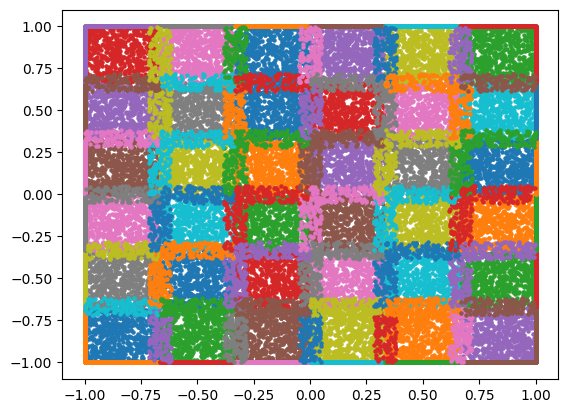

In [49]:
int_point_number=24000
ext_point_number=20000
width=6
int_point_per_model=int_point_number//width**2
ext_point_per_model=ext_point_number//width**2

sigma=0.1
boundary_width=0.05

models=[]
for i in range(width**2):
    yi=i//width
    xi=i%width
    range_model=np.array([
        [-1+2*xi/width,-1+2*(xi+1)/width],
        [-1+2*yi/width,-1+2*(yi+1)/width]
    ])
    X_int=make_points_inside(int_point_per_model,range_model)
    X_bounds=[]
    if i%width==0:
        X_bounds.append(make_points_line(ext_point_per_model//4,'x',-1,[-1+2*yi/width,-1+2*(yi+1)/width]))
    if i%width==width-1:
        X_bounds.append(make_points_line(ext_point_per_model//4,'x',1,[-1+2*yi/width,-1+2*(yi+1)/width]))
    if i//width==0:
        X_bounds.append(make_points_line(ext_point_per_model//4,'y',-1,[-1+2*xi/width,-1+2*(xi+1)/width]))
    if i//width==width-1:
        X_bounds.append(make_points_line(ext_point_per_model//4,'y',1,[-1+2*xi/width,-1+2*(xi+1)/width]))

    plt.scatter(X_int[:,0],X_int[:,1],label=f'{i}',s=5)

    try:
        X_boundary=np.concatenate(X_bounds)
        plt.scatter(X_boundary[:,0],X_boundary[:,1],label=f'boundary {i}',s=5)
    except ValueError:
        X_boundary=np.empty((0,2))
    
    models.append(
        PDESolverLaplace(
            X_int=X_int,
            X_boundary=X_boundary,
            sigma=sigma,
            name=f'model {i}')
    )
    if i%width>0:
        range_neighbors=np.array([
            [-1+2*xi/width-boundary_width,-1+2*xi/width+boundary_width],
            [-1+2*yi/width,-1+2*(yi+1)/width]
        ])
        #X_shared=make_points_line(ext_point_per_model//4,'x',-1+2*xi/width,[-1+2*yi/width,-1+2*(yi+1)/width])
        X_shared=make_points_inside(ext_point_per_model//4,range_neighbors)
        models[-1].add_neighbors([models[-2]], [X_shared])
        models[-2].add_neighbors([models[-1]], [X_shared])
        plt.scatter(X_shared[:,0],X_shared[:,1],label=f'shared {models[-1]} {models[-2]}',s=5)
    if i//width>0:
        range_neighbors=np.array([
            [-1+2*xi/width,-1+2*(xi+1)/width],
            [-1+2*yi/width-boundary_width,-1+2*(yi)/width+boundary_width]
        ])
        X_shared=make_points_inside(ext_point_per_model//4,range_neighbors)
        #X_shared=make_points_line(ext_point_per_model//4,'y',-1+2*yi/width,[-1+2*xi/width,-1+2*(xi+1)/width])
        models[-1].add_neighbors([models[-1-width]], [X_shared])
        models[-1-width].add_neighbors([models[-1]], [X_shared])
        plt.scatter(X_shared[:,0],X_shared[:,1],label=f'shared {models[-1]} {models[-1-width]}',s=5)

plt.show()

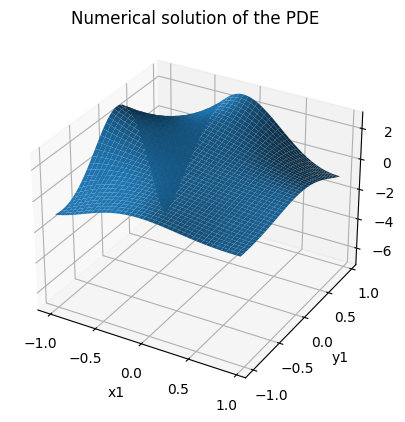

In [50]:
PDESolverLaplace.joint_fit(models,f,real_u,1e-7)
aggregate=partial(dumb_aggregate,models=models,width=width)
fig=plot_vectorized_function(aggregate,0.05)
plt.title('Numerical solution of the PDE')
plt.show()

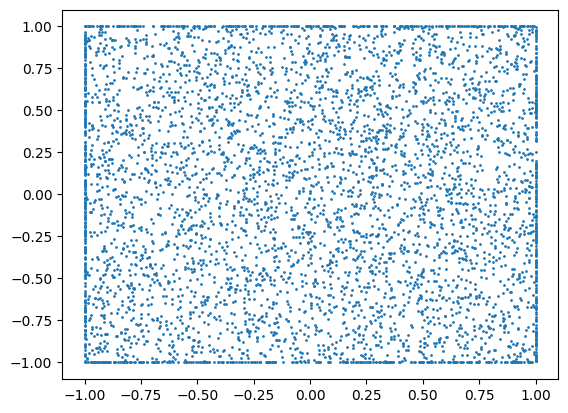

In [51]:
model0=PDESolverLaplace(
        X_int=make_points_inside(4000),
        X_boundary=make_points_boundary(1000),
        sigma=sigma,
        name=f'model 0')
plt.figure()
plt.scatter(model0.X_all[:,0],model0.X_all[:,1],s=1)
plt.show()
#model0.fit_interior(f,real_u,tau,dtau,use_shared=False,nugget=1e-5)
model0.setup_fit(f,real_u,nugget=1e-7)
model0.a = np.concatenate(
    [
        model0.g_vec,
        model0.f_vec,
    ]
)
model0.coeff = model0.K_inv @ model0.a

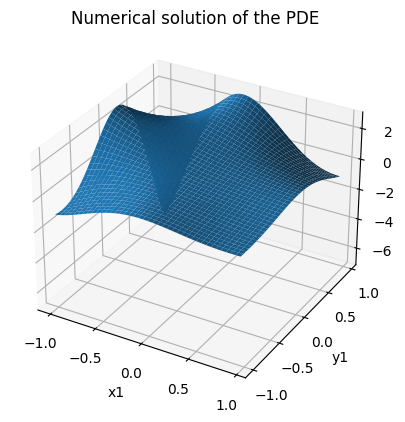

In [52]:
fig=plot_vectorized_function(model0,0.05)
plt.title('Numerical solution of the PDE')
plt.show()

In [53]:
x = y = np.arange(-1.0, 1.0, 0.01)
X, Y = np.meshgrid(x, y)
U_real=np.array([real_u([x,y]) for x,y in zip(np.ravel(X), np.ravel(Y))])
U0 = model0(np.stack([X.flatten(),Y.flatten()],axis=-1))
U_agg= aggregate(np.stack([X.flatten(),Y.flatten()],axis=-1))
U_indiv=models[0](np.stack([X.flatten(),Y.flatten()],axis=-1))
#U_left=u_left(np.stack([X.flatten(),Y.flatten()],axis=-1))
#U_right=u_right(np.stack([X.flatten(),Y.flatten()],axis=-1))

In [54]:
np.linalg.norm(U0-U_real,ord=np.inf)

0.00020894162481976952

In [55]:
err_agg=np.linalg.norm(U_agg-U_real,ord=np.inf)
err_agg

0.0008722353760521884

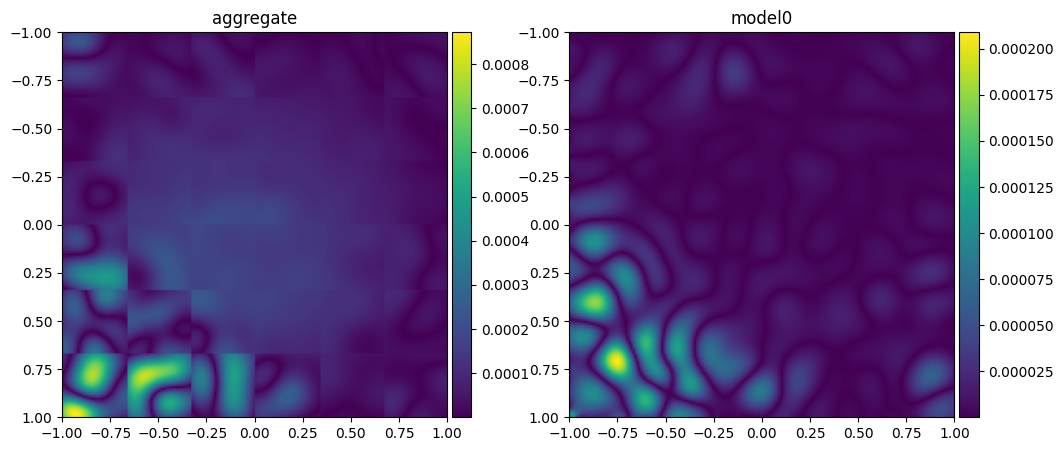

In [56]:
fig,axes=plt.subplots(1,2,figsize=(12,5))
im = axes[0].imshow(np.abs(U_agg-U_real).reshape(X.shape),extent=[-1,1,1,-1])
#axes[0].scatter(u_left.X_int[:,0],u_left.X_int[:,1],c='g',s=2)
#axes[0].scatter(x_sample[:,0],x_sample[:,1],c='k')
axes[0].title.set_text('aggregate')

divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im2 = axes[1].imshow(np.abs(U0-U_real).reshape(X.shape),extent=[-1,1,1,-1])
#axes[1].scatter(u_right.X_int[:,0],u_right.X_int[:,1],c='g',s=2)
#axes[1].scatter(x_sample[:,0],x_sample[:,1],c='k')
axes[1].title.set_text('model0')

divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

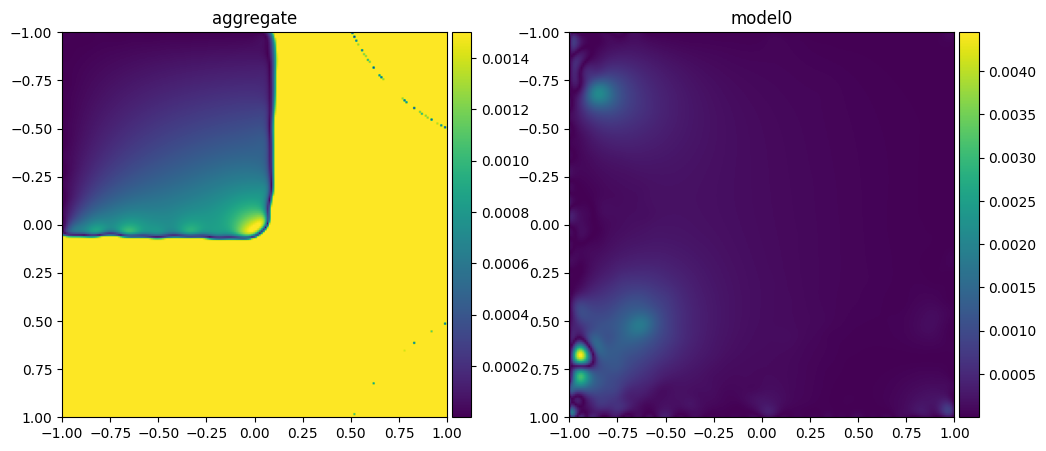

In [ ]:
fig,axes=plt.subplots(1,2,figsize=(12,5))
im = axes[0].imshow(np.clip(np.abs(U_indiv-U_real),0,err_agg).reshape(X.shape),extent=[-1,1,1,-1])
#axes[0].scatter(u_left.X_int[:,0],u_left.X_int[:,1],c='g',s=2)
#axes[0].scatter(x_sample[:,0],x_sample[:,1],c='k')
axes[0].title.set_text('aggregate')

divider = make_axes_locatable(axes[0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

im2 = axes[1].imshow(np.abs(U0-U_real).reshape(X.shape),extent=[-1,1,1,-1])
#axes[1].scatter(u_right.X_int[:,0],u_right.X_int[:,1],c='g',s=2)
#axes[1].scatter(x_sample[:,0],x_sample[:,1],c='k')
axes[1].title.set_text('model0')

divider = make_axes_locatable(axes[1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')